# An analysis of the *Mendoza Line* in MLB batting statistics.
-----

The *Mendoza Line* is common U.S. slang referring to the threshold for seriously below average performance.
The term originated in baseball, referring to the batting average of shortstop Mario Mendoza.
For those unfamiliar with the origin of the term, there is good background in the [wikipedia entry on the Mendoza Line] and [this column] from the St. Louis Post-Dispatch.  

The term has made Mendoza's last name famous since it was first coined in 1979, but we should verify the figure and analyze where this level of performance falls in the spectrum of other major league batters.
In addition, we'll look at how batting averages over time compare to this figure.

The data used in this analysis comes from SeanLahman.com's [baseball database](http://www.seanlahman.com/baseball-archive/statistics/).

[wikipedia entry on the Mendoza Line]: https://en.wikipedia.org/wiki/Mendoza_Line

[this column]: http://www.stltoday.com/sports/baseball/professional/branded-for-life-with-the-mendoza-line/article_cff05af5-032e-5a29-b5a8-ecc9216b0c02.html

### Table of contents:
1.  Set up
2.  Data  
    2.1  Sources  
    2.2  Data wrangling and initial observations  
3.  Exploration and analysis  
    3.1  How bad was this average in the years leading up to 1979?  
    3.2  What percent of batters are below the Mendoza Line over time?
4.  Summary

## 1. Set up
-----
Load the required libraries:

In [1]:
import numpy as np
import pandas as pd
import platform
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, percentileofscore
%matplotlib inline

For readers and reviewers, the versions of the major software components are:

In [2]:
print('python version:', platform.python_version())
print(pd.__name__, 'version', pd.__version__)
print(np.__name__, 'version', np.__version__)

python version: 3.6.1
pandas version 0.20.1
numpy version 1.12.1


## 2. Data
-----

### 2.1 Sources
As noted earlier, the data used comes from SeanLahman.com's baseball database. Specifically, I used this [dataset](http://seanlahman.com/files/database/baseballdatabank-2017.1.zip) which was updated February 26, 2017 with statistics through the 2016 season.

While the zip repository contains 27 different .csv files covering various statistics, we're only going to use a subset:

1. Master.csv --> player names and biographical data
2. Batting.csv --> batting stastics
3. Salaries.csv --> payroll data
4. Appearances.csv --> positional info

### 2.2 Data wrangling and initial observations
Import each of the .csv files into a pandas DataFrame object:

In [3]:
directory = 'core/'
master_df = pd.read_csv(directory + 'Master.csv')
batting_df = pd.read_csv(directory + 'Batting.csv')
appearances_df = pd.read_csv(directory + 'Appearances.csv')

Look at the master table to make sure it loaded correctly:

In [4]:
master_df.head()

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,Aardsma,David Allan,215.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
1,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,...,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
2,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,...,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01
3,aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,...,Aase,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01
4,abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,...,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01


First, let's see if we can find Mario Mendoza in our database...

In [5]:
mendozas = master_df.loc[master_df['nameLast'] == 'Mendoza']
mendozas

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
11495,mendoca01,1974.0,11.0,4.0,Venezuela,Bolivar,Ciudad Bolivar,NaN,NaN,NaN,...,Mendoza,Carlos Ramon,160.0,71.0,L,L,1997-09-03,2000-09-30,mendc001,mendoca01
11496,mendolu01,1983.0,10.0,31.0,Mexico,Veracruz,Veracruz,NaN,NaN,NaN,...,Mendoza,Luis Alonso,245.0,75.0,R,R,2007-09-08,2013-09-06,mendl001,mendolu01
11497,mendoma01,1950.0,12.0,26.0,Mexico,Chihuahua,Chihuahua,NaN,NaN,NaN,...,Mendoza,Mario,170.0,71.0,R,R,1974-04-26,1982-05-22,mendm101,mendoma01
11498,mendomi01,1933.0,11.0,16.0,Cuba,NaN,Ceiba del Agua,NaN,NaN,NaN,...,Mendoza,Cristobal Rigoberto,180.0,72.0,R,R,1970-04-09,1970-06-07,mendm103,mendomi01
11499,mendomi02,1955.0,11.0,26.0,USA,CA,Inglewood,NaN,NaN,NaN,...,Mendoza,Michael Joseph,215.0,77.0,R,R,1979-09-07,1979-09-26,mendm102,mendomi02
11500,mendora01,1972.0,6.0,15.0,Panama,Los Santos,Los Santos,NaN,NaN,NaN,...,Mendoza,Ramiro,154.0,74.0,R,R,1996-05-25,2005-09-01,mendr001,mendora01


Judging by the first names and the dates played compared to the biographical info in the background reading, it's pretty easy to find our man in the third row, born in Chihuahua, Mexico in 1950. Let's save his player ID in a variable **mendoza_ID** so we can look up his stats.

In [6]:
mendoza_ID = mendozas[mendozas['nameFirst'] == 'Mario']['playerID'].values[0]
mendoza_ID

'mendoma01'

Now, let's look up Mario Mendoza's batting statistics.  First, let's look at the batting dataframe:

In [7]:
batting_df.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,NaN


The columns in the batting_df dataframe have the following labels:

In [8]:
#playerID       Player ID code
#yearID         Year
#stint          player's stint (order of appearances within a season)
#teamID         Team
#lgID           League
#G              Games
#AB             At Bats
#R              Runs
#H              Hits
#2B             Doubles
#3B             Triples
#HR             Homeruns
#RBI            Runs Batted In
#SB             Stolen Bases
#CS             Caught Stealing
#BB             Base on Balls
#SO             Strikeouts
#IBB            Intentional walks
#HBP            Hit by pitch
#SH             Sacrifice hits
#SF             Sacrifice flies
#GIDP           Grounded into double plays

Let's examine Mendoza's numbers:

In [9]:
mendoza_batting_df = batting_df[batting_df['playerID'] == mendoza_ID]
mendoza_batting_df

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
52313,mendoma01,1974,1,PIT,NL,91,163,10,36,1,...,15.0,1.0,1.0,8,35.0,2.0,1.0,3.0,2.0,6.0
53210,mendoma01,1975,1,PIT,NL,56,50,8,9,1,...,2.0,0.0,0.0,3,17.0,0.0,0.0,3.0,0.0,1.0
54112,mendoma01,1976,1,PIT,NL,50,92,6,17,5,...,12.0,0.0,1.0,4,15.0,1.0,0.0,0.0,1.0,3.0
55054,mendoma01,1977,1,PIT,NL,70,81,5,16,3,...,4.0,0.0,0.0,3,10.0,0.0,0.0,2.0,0.0,1.0
56009,mendoma01,1978,1,PIT,NL,57,55,5,12,1,...,3.0,3.0,1.0,2,9.0,1.0,3.0,2.0,0.0,0.0
56962,mendoma01,1979,1,SEA,AL,148,373,26,74,10,...,29.0,3.0,0.0,9,62.0,0.0,1.0,13.0,5.0,12.0
57921,mendoma01,1980,1,SEA,AL,114,277,27,68,6,...,14.0,3.0,4.0,16,42.0,0.0,0.0,11.0,1.0,5.0
58862,mendoma01,1981,1,TEX,AL,88,229,18,53,6,...,22.0,2.0,1.0,7,25.0,0.0,1.0,14.0,3.0,9.0
59820,mendoma01,1982,1,TEX,AL,12,17,1,2,0,...,0.0,0.0,0.0,0,4.0,0.0,0.0,1.0,0.0,1.0


Create a quick summary of Mendoza's hits and at bats per year, and calculate his batting average **('BA')** - note the convention is to round this to three decimals places:

In [10]:
def calculate_BA(batting_df):
    return (batting_df['H']/batting_df['AB']).round(3)

In [11]:
mendoza_data = pd.DataFrame.from_items([('BA', calculate_BA(mendoza_batting_df)),
                             ('H', mendoza_batting_df['H']), 
                             ('AB', mendoza_batting_df['AB'])])
mendoza_data.index = mendoza_batting_df['yearID']
mendoza_data

,BA,H,AB
yearID,,,
1974,0.221,36,163
1975,0.180,9,50
1976,0.185,17,92
1977,0.198,16,81
1978,0.218,12,55
1979,0.198,74,373
1980,0.245,68,277
1981,0.231,53,229
1982,0.118,2,17


Let's look at his typical batting average in the years up through (and including) 1979 when the phrase was coined:

In [12]:
end_year = 1979
start_year = mendoza_data.index.values.min()
print('Average {} - {} batting average: {:4.3f}'.format(start_year, end_year, 
      mendoza_data[(mendoza_data.index) <= end_year]['BA'].mean()))

Average 1974 - 1979 batting average: 0.200


#### The Mendoza Line quantified and verified: he was a .200 hitter 

Now, this "average of averages" would give equal weighting to his batting averages from each year regardless of the number of at bats.  Let's redo the previous calculation using the actual hits and at bats from each season:

In [13]:
print('Cumulative {} - {} batting average: {:4.3f}'.format(start_year, end_year,
    float(mendoza_data[(mendoza_data.index) <= end_year]['H'].sum()/mendoza_data[(mendoza_data.index) <= end_year]['AB'].sum())))

Cumulative 1974 - 1979 batting average: 0.201


Looks like the cumulative batting average over that period was almost consistent with the average of his batting averages, so the initial figure wasn't skewed by any outlier years.
  
How did he fare from 1979 through the end of his career in 1982?

In [14]:
final_career_year = mendoza_data.index.values.max()
print('{} - {} batting average: {:4.3f}'.format(end_year+1, final_career_year, 
      float(mendoza_data[(mendoza_data.index) > end_year]['H'].sum()/mendoza_data[(mendoza_data.index) > end_year]['AB'].sum())))

1980 - 1982 batting average: 0.235


He was a little better those last few years, but unfortunately the saying had already become a cultural idoim and the "Mendoza Line" was memorialized as a batting average of **0.200**. 

In [15]:
MENDOZA_LINE = 0.200

## 3. Exploration and analysis
-----

### 3.1 How bad was this average in the years leading up to 1979?
In order to quantify how mediocre a performance batting .200 was in 1979 when the phrase was coined, I want to look at typical batting averages in this time period. To do this, I need to adjust the batting_df dataset in a few different ways:
* Look only at data in the 5 year window from 1975 - 1979
* Remove pitchers
* Remove players without at least 50 at bats in a season *(which could be stints with multiple teams in the same season)*

#### First, create a new dataframe with just the batting data from 1975 to 1979 (inclusive)

In [16]:
def stat_window(df, start_year, end_year):
    search = str(start_year) + ' <= yearID <= ' + str(end_year)
    return df.query(search)

start_year = 1975
end_year = 1979
batting_window = stat_window(batting_df, start_year, end_year)
print(len(batting_window), "batting data records from {} - {}".format(start_year,
                                                                            end_year))
batting_window.head()

4698 batting data records from 1975 - 1979


,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
52665,aaronha01,1975,1,ML4,AL,137,465,45,109,16,...,60.0,0.0,1.0,70,51.0,3.0,1.0,1.0,6.0,15.0
52666,abbotgl01,1975,1,OAK,AL,30,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
52667,acostcy01,1975,1,PHI,NL,6,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
52668,adamsgl01,1975,1,SFN,NL,61,90,10,27,2,...,15.0,1.0,0.0,11,25.0,0.0,1.0,0.0,1.0,1.0
52669,alburvi01,1975,1,MIN,AL,33,1,0,0,0,...,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
players_set = set(batting_window['playerID'])
print(len(players_set), "unique players with batting records during this period")

1436 unique players with batting records during this period


#### Next, remove pitchers from the dataset.  
Pitchers are defined as players with more than one appearance as pitcher during a season. One appeance is used as the threshold to allow for fielders who might pitch rarely during an extra innings situation. This could lead to slight errors on edge cases of fielders who routinely pitched or players who switched positions during their career, but this would be very rare case during the time period being analyzed.

In [18]:
# Create a set of all players with more than one game pitched in a stint or season
min_G_p = 1
all_pitchers = set(appearances_df[appearances_df['G_p'] > min_G_p]['playerID'])

# remove these players from the batting dataframe
batters_set = set(x for x in batting_window['playerID'] if x not in all_pitchers)
print(len(batters_set), "unique non-pitchers in {} - {}".format(start_year, end_year))

815 unique non-pitchers in 1975 - 1979


In [19]:
def remove_position(df, position):
    non_position = [x not in position for x in df['playerID']]
    return df[non_position]

batting_window = remove_position(batting_window, all_pitchers)
print(len(batting_window), 'batting data records with pitchers removed')
print(len(set(batting_window['playerID'])), 
      "unique players, should match unique non-pitchers in cell above")
batting_window.head()

2729 batting data records with pitchers removed
815 unique players, should match unique non-pitchers in cell above


,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
52665,aaronha01,1975,1,ML4,AL,137,465,45,109,16,...,60.0,0.0,1.0,70,51.0,3.0,1.0,1.0,6.0,15.0
52668,adamsgl01,1975,1,SFN,NL,61,90,10,27,2,...,15.0,1.0,0.0,11,25.0,0.0,1.0,0.0,1.0,1.0
52671,alexaga01,1975,1,SFN,NL,3,3,1,0,0,...,0.0,0.0,0.0,1,2.0,0.0,0.0,0.0,0.0,0.0
52672,alexama01,1975,1,OAK,AL,63,10,16,1,0,...,0.0,17.0,10.0,1,1.0,0.0,0.0,0.0,0.0,0.0
52673,allendi01,1975,1,PHI,NL,119,416,54,97,21,...,62.0,11.0,2.0,58,109.0,4.0,2.0,1.0,4.0,19.0


#### Next, remove players without at least 50 at bats in that year. 
The intent here is to try to remove "noisy" data points from players who didn't have at least 50 at bats in a season, which might included short-term call-ups from the minor leagues, injured players, etc.  However, we must allow for players to achieve this minimum in a combination of 'stints' across different teams in the same season.
***To do this, we create a multi-index*** to sum the games played ('G') data by playerID and yearID (to aggregate seasons with multiple stints), so that we can look up our data by player, by year:

In [20]:
def get_player_year_sum(df, field):
    
    grouped = df.groupby(['playerID', 'yearID'], as_index=False).sum()
    
    index_arrays = [grouped['playerID'], grouped['yearID']]
    multi_index = pd.MultiIndex.from_arrays(index_arrays, names = ['playerID', 'yearID'])
    return pd.Series(grouped[field].values, index=multi_index)

stat = 'AB'
player_year_stats = get_player_year_sum(batting_window, stat)
player_year_stats.head(10)

playerID   yearID
aaronha01  1975      465
           1976      271
adamsbo04  1977       24
adamsgl01  1975       90
           1976       74
           1977      269
           1978      310
           1979      326
adamsmi02  1976       29
           1977        2
dtype: int64

Create a boolean array to check for minimum criteria (at bats) in the season:

In [21]:
min_stat = 50
required_min = []
for x in batting_window.iterrows():
    if player_year_stats[x[1][0], x[1][1]] >= min_stat:
        required_min.append(True)
    else:
        required_min.append(False)

batting_window = batting_window[required_min]
print(len(batting_window), 'batting data records with minimum of {} {}'.format(min_stat, stat))

2163 batting data records with minimum of 50 AB


#### Now that we've cleaned up this data, we can analyze the distribution of batting averages.  

In [22]:
BAs_window = batting_window['H']/batting_window['AB']
BAs_window.describe()

count    2163.000000
mean        0.251495
std         0.046805
min         0.000000
25%         0.227898
50%         0.255556
75%         0.280255
max         0.600000
dtype: float64

From the describe() statement above, the mean of the batting averages was .251, with a standard deviation of 0.47 **- so the Mendoza Line of .200 was about one standard deviation below the mean.**  We can also graph the distribution of batting averages to get a visual feeling for the distribution.

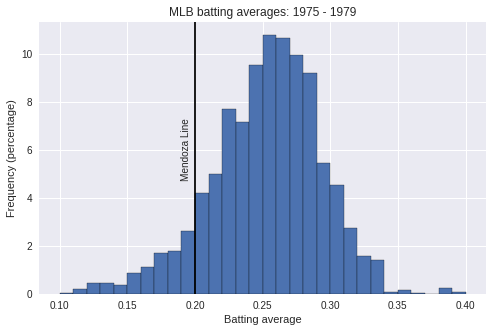

In [23]:
BA_bins = [x/1000 for x in range(100,410,10)]
plt.rcParams['figure.figsize'] = 8, 5
BAs_window.hist(bins=BA_bins, normed = True, edgecolor='black')
plt.title('MLB batting averages: 1975 - 1979')
plt.axvline(x=0.200, color='black')
plt.text(.190, 7 , "Mendoza Line", rotation=90)
plt.xlabel('Batting average')
plt.ylabel('Frequency (percentage)')
plt.show()

Calculating some statistics based on a normal distribution...

In [24]:
mendoza_Z = (MENDOZA_LINE - BAs_window.mean())/BAs_window.std(ddof=0)
print("The Z score of a .200 batting average is {:4.2f}".format(mendoza_Z))
print("Assuming a normal distribution of batting averages, this would place .200 above",
      "only {:3.1f}% of batters".format(100*norm.cdf(mendoza_Z)))

The Z score of a .200 batting average is -1.10
Assuming a normal distribution of batting averages, this would place .200 above only 13.6% of batters


However, the normal distribution is only and approximation of the data.  We can look at the actual percentile rankings of the batting averages to calculate precisely what percentage of batters would fall below the Mendoza Line:

In [25]:
BAs_window.quantile([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])

0.0    0.000000
0.1    0.198238
0.2    0.221053
0.3    0.234568
0.4    0.246216
0.5    0.255556
0.6    0.264940
0.7    0.274510
0.8    0.285714
0.9    0.301037
1.0    0.600000
dtype: float64

Eyeballing the deciles above would imply that and average of .200 would fall just north of the tenth precentile (where only 10% of observations would be below this point).  This is even worse than what the normal distribution would imply. We can use **percentileofscore** from the scipy.stats module to figure out precisely what percentage of scores were below .200:

In [26]:
def mendoza_percentile(series):
    return percentileofscore(series, MENDOZA_LINE, kind="strict")

print("Given the actual distribution, a .200 batting average was above", 
      "only {:3.1f}% of batters".format(mendoza_percentile(BAs_window)))

Given the actual distribution, a .200 batting average was above only 10.3% of batters


#### Conculsion: 
1. The term "Mendoza Line" refers to a performance of batting average of approximately .200, as verified by Mario Mendoza's actual batting average in the years before the term was coined.  
2. This level of performance in the 1975-1979 time frame would have placed a batter in only the 10th percentile. Said another way, almost *90% of batters had a higher average* when we removed pitchers and players without a minimum number of at bats. 

### 3.2 What percent of batters are below the "Mendoza Line" over time?

In the 1975-1979 time frame, when the term Mendoza Line was coined, batting .200 put a player in roughly the 10th percentile of eligible batters (those with at least 50 ABs, excluding pitchers). I'd like to know how this level varied over time thereafter (from 1980 onward). 
  
**Specifically, what percent of batters are below .200 each year?**

#### First, create a dataset with just the figures from 1980 forward

In [27]:
start_year = 1980
end_year = batting_df['yearID'].max()

batting_window = stat_window(batting_df, start_year, end_year)
print(len(batting_window), "batting data records from {} - {}".format(
                            start_year, end_year))
batting_window.head()

45453 batting data records from 1980 - 2016


,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
57363,aasedo01,1980,1,CAL,AL,40,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
57364,abbotgl01,1980,1,SEA,AL,31,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
57365,adamsgl01,1980,1,MIN,AL,99,262,32,75,11,...,38.0,2.0,4.0,15,26.0,1.0,0.0,6.0,4.0,11.0
57366,aguaylu01,1980,1,PHI,NL,20,47,7,13,1,...,8.0,1.0,1.0,2,3.0,0.0,0.0,0.0,1.0,0.0
57367,aikenwi01,1980,1,KCA,AL,151,543,70,151,24,...,98.0,1.0,0.0,64,88.0,3.0,7.0,0.0,9.0,23.0


#### Again, remove the pitchers

In [28]:
batting_window = remove_position(batting_window, all_pitchers)
print(len(batting_window), 'batting data records with pitchers removed')

23510 batting data records with pitchers removed


#### Next, remove players without at least 50 at bats in that year. 
Similar to the process above, we need to create a multiindex to allow for players to have different 'stints' across different teams in the same season.  Note that to qualify for awards like the batting title, the minimum level of appearances is much higher.  

Create the at bats multiindex for the 1980 onward batting data:

In [29]:
stat = 'AB'
player_year_stats = get_player_year_sum(batting_window, stat)
player_year_stats.head(10)

playerID   yearID
abadan01   2001        1
           2003       17
           2006        3
abbotje01  1997       38
           1998      244
           1999       57
           2000      215
           2001       42
abbotku01  1993       61
           1994      345
dtype: int64

And remove the players without less than 50 ABs in a year from our post-1980 batting dataframe

In [30]:
min_stat = 50
required_min = []
for x in batting_window.iterrows():
    if player_year_stats[x[1][0], x[1][1]] >= min_stat:
        required_min.append(True)
    else:
        required_min.append(False)

batting_window = batting_window[required_min]
print(len(batting_window), 'batting data records with minimum of {} {}'.format(min_stat, stat))

18503 batting data records with minimum of 50 AB


In [31]:
batting_window.head(10)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
57365,adamsgl01,1980,1,MIN,AL,99,262,32,75,11,...,38.0,2.0,4.0,15,26.0,1.0,0.0,6.0,4.0,11.0
57367,aikenwi01,1980,1,KCA,AL,151,543,70,151,24,...,98.0,1.0,0.0,64,88.0,3.0,7.0,0.0,9.0,23.0
57368,aingeda01,1980,1,TOR,AL,38,111,11,27,6,...,4.0,3.0,0.0,2,29.0,0.0,1.0,1.0,0.0,3.0
57370,alexaga01,1980,1,CLE,AL,76,178,22,40,7,...,31.0,0.0,4.0,17,52.0,1.0,0.0,0.0,3.0,9.0
57373,allenga01,1980,1,BOS,AL,36,70,9,25,6,...,10.0,2.0,2.0,13,11.0,0.0,0.0,1.0,1.0,1.0
57374,allenki01,1980,1,SEA,AL,23,51,9,12,3,...,3.0,10.0,3.0,8,3.0,2.0,1.0,2.0,0.0,1.0
57376,almonbi01,1980,1,MON,NL,18,38,2,10,1,...,3.0,0.0,0.0,1,5.0,0.0,0.0,0.0,1.0,2.0
57377,almonbi01,1980,2,NYN,NL,48,112,13,19,3,...,4.0,2.0,0.0,8,27.0,1.0,0.0,0.0,0.0,0.0
57378,alstode01,1980,1,CLE,AL,52,54,11,12,1,...,9.0,2.0,4.0,5,7.0,2.0,2.0,1.0,2.0,1.0
57379,anderji01,1980,1,SEA,AL,116,317,46,72,7,...,30.0,2.0,4.0,27,39.0,1.0,3.0,6.0,2.0,5.0


In [32]:
#  helper function to return an array with the qualifying batting averages for any given year
def get_annual_BA(year):
    annual_data = batting_window[batting_window['yearID'] == year]
    return (annual_data['H']/annual_data['AB']).values

# create a dataframe with a column containing the qualifying batting averages for each year
# note that the columns will be of varying lengths, but pandas will pad the missing values with NaN

BA_dict = {x: get_annual_BA(x) for x in range(start_year, end_year+1)}
annual_BA_df = pd.DataFrame.from_dict(BA_dict, orient='index')
annual_BA_df = annual_BA_df.transpose()
annual_BA_df.head()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,0.286260,0.209091,0.257576,0.250000,0.277778,0.190083,0.210526,0.205742,0.180723,0.176471,...,0.197368,0.309091,0.293073,0.254799,0.252988,0.208333,0.268116,0.248120,0.290375,0.293269
1,0.278085,0.214286,0.267857,0.302439,0.205128,0.278788,0.250000,0.324930,0.265957,0.175258,...,0.282645,0.295567,0.175439,0.233161,0.273273,0.246154,0.252604,0.316547,0.215054,0.147541
2,0.243243,0.266476,0.281116,0.230435,0.228916,0.270492,0.225256,0.266234,0.247423,0.220588,...,0.271084,0.263666,0.201923,0.256484,0.280899,0.257143,0.192857,0.245020,0.288462,0.217778
3,0.224719,0.186992,0.204545,0.223443,0.222749,0.199095,0.219388,0.200000,0.250000,0.232198,...,0.233333,0.232044,0.217391,0.180645,0.266667,0.225700,0.283784,0.288425,0.245283,0.249158
4,0.357143,0.223022,0.256494,0.266075,0.251337,0.264935,0.245370,0.240741,0.267352,0.295345,...,0.250000,0.292639,0.237838,0.295082,0.172414,0.244186,0.263889,0.168317,0.240000,0.253968


#### Quick detour: 
Let's take a look at the 1980's to get a feel for how batting averages are distributed by year

In [33]:
eighties = annual_BA_df.loc[:,:1989]
eighties.head()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989
0,0.286260,0.209091,0.257576,0.250000,0.277778,0.190083,0.210526,0.205742,0.180723,0.176471
1,0.278085,0.214286,0.267857,0.302439,0.205128,0.278788,0.250000,0.324930,0.265957,0.175258
2,0.243243,0.266476,0.281116,0.230435,0.228916,0.270492,0.225256,0.266234,0.247423,0.220588
3,0.224719,0.186992,0.204545,0.223443,0.222749,0.199095,0.219388,0.200000,0.250000,0.232198
4,0.357143,0.223022,0.256494,0.266075,0.251337,0.264935,0.245370,0.240741,0.267352,0.295345


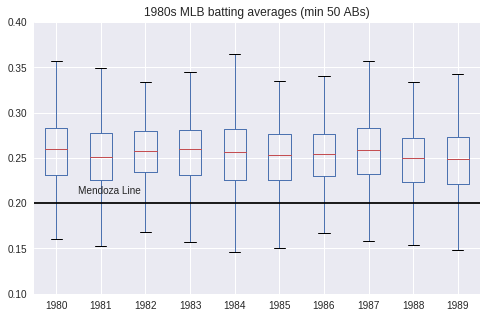

In [34]:
eighties.plot.box()
plt.title('1980s MLB batting averages (min 50 ABs)')
plt.ylim(.1, .4)
plt.axhline(y=0.200, color='black')
plt.text(1.5, .21 , "Mendoza Line")
plt.show()

As shown in the box plot above, the middle 50% of the observed batting averages fall in a band roughly .050 wide centered in the .250 - .260 area.  The maximum is generally in the .340-.360 area and the min is in the .150 - .170 area.  It looks like the .200 Mendoza Line remains a very low average.  
  
#### But how low is low? Let's get the percetile represented by .200 in each year.

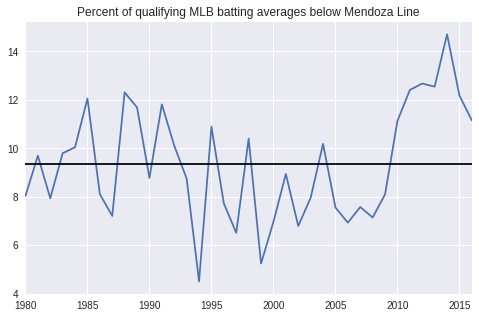

In [35]:
# helper function to eliminate NaNs from series before using to calculate percentiles
def no_NaNs(series):
    return [x for x in series if x > 0] 

# test = [mendoza_percentile(no_NaNs(eighties[x])) for x in [1980, 1981, 1982]]
min_year = batting_window['yearID'].min()
max_year = batting_window['yearID'].max()
years = [x for x in range(min_year, max_year+1)]
mendoza_pct_by_year = pd.Series([mendoza_percentile(no_NaNs(annual_BA_df[year])) for year in years], index=years)
mendoza_pct_by_year.plot()
plt.title('Percent of qualifying MLB batting averages below Mendoza Line')
ave = mendoza_pct_by_year.mean()
plt.axhline(y=ave, color='black')
plt.show()

#### Conculsion: 
1. The plot above shows that the percentage of qualifying batters (non-pitchers, with at least 50 ABs in a season across teams) batting below the Mendoza Line ranged from a low of under 5% in 1994 to a higher of nearly 15% in 2014.  
1. The horizontal line above shows the average of the percentage of batters below the Mendoza Line, which has been just below 10% over this time period. 

## 4. Summary
-----
As verified above, the Mendoza Line refers to a batting average of .200, corresponding the Mario Mendoza's actual average in the years leading up to the phrase first appearing in 1979. To quantify this amount, we showed that this batting average placed Mario Mendoza in the 10th percentile in the years leading up to this phrase being coined. In the years since then, the percentage of qualifying players batting below the Mendoza Line in a given year has ranged from under 5% to over 14%, while on average just under 10% of players bat below the Mendoza Line each year.